# Pump it Up: Data Mining the Water Table

## Data load and preprocessing

### Data load

In [1]:
# DATA
# =======================
import pandas as pd
import numpy as np
import time
pd.set_option('display.max_columns', 0)

#Visualization
# =======================
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

#Warnings
#========================
import warnings
warnings.filterwarnings("ignore")

In [2]:
X_train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')

y_train = pd.read_csv('../data/target_train.csv')
y_test = pd.DataFrame([X_test['id'].values,['0,' * (len(X_test)-1)][0].split(',')])
y_test = y_test.transpose()
y_test.columns = ['id','status_group']

In [3]:
X_train = X_train.drop_duplicates()

In [4]:
X_train = X_train.merge(y_train, on='id')
X_test = X_test.merge(y_test, on='id')

In [5]:
df = pd.concat([X_train,X_test])

### Preprocessing

#### Nulls

In [6]:
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [7]:
print("Nulls:")
cols_nul= list()
for col in df.columns :
        if df[col].isna().sum() *100 / len(df) >0.0:
            cols_nul += [col]
            print(f"\t{col}: {round(df[col].isna().sum() *100 / len(df),3)}")

Nulls:
	funder: 6.066
	installer: 6.104
	subvillage: 0.633
	public_meeting: 5.596
	scheme_management: 6.527
	scheme_name: 47.486
	permit: 5.108


Scheme_name tiene un porcentaje de null muy alto, el resto está cerca del 5% por lo que podemos imputar estos

In [8]:
simp_imp = SimpleImputer(strategy=  'most_frequent')
miss_ind = MissingIndicator()

In [9]:
df['funder'] = simp_imp.fit_transform(df[['funder']])
df['subvillage'] = simp_imp.fit_transform(df[['subvillage']])
df['installer'] = simp_imp.fit_transform(df[['installer']])
df['public_meeting'] = simp_imp.fit_transform(df[['public_meeting']])
df['scheme_management'] = simp_imp.fit_transform(df[['scheme_management']])
df['scheme_name'] = miss_ind.fit_transform(df[['scheme_name']])
df['permit'] = simp_imp.fit_transform(df[['permit']])

#### Analisis por tipo de columna

##### Date

In [10]:
df['year'] = df['date_recorded'].apply(lambda x : int(str(x).split('-')[0]))
df['month'] = df['date_recorded'].apply(lambda x : int(str(x).split('-')[1]))
df['day'] = df['date_recorded'].apply(lambda x : int(str(x).split('-')[1]))

#for impute 0s
most_freq_cons = {
    2001 : df[['year','construction_year']].value_counts().loc[2001].index[0] ,
    2002 : df[['year','construction_year']].value_counts().loc[2001].index[0] ,
    2004 : df[['year','construction_year']].value_counts().loc[2004].index[1] ,
    2011 : df[['year','construction_year']].value_counts().loc[2011].index[1] ,
    2012 : df[['year','construction_year']].value_counts().loc[2012].index[1] ,
    2013 : df[['year','construction_year']].value_counts().loc[2013].index[1] }
ind_cons_cero = df[df['construction_year'] == 0].index
df.loc[ind_cons_cero, 'construction_year'] = df.loc[ind_cons_cero,'year'].apply(lambda x: most_freq_cons[x] )

df['dif_year'] = df['year'] - df['construction_year']

seas = {
    1 : 0,
    2 : 0,
    3 : 1,
    4 : 1,
    5 : 1,
    6 : 2,
    7 : 2,
    8 : 2,
    9 : 3,
    10: 3,
    11: 3,
    12: 0,
}
df['seas'] = df['month'].apply(lambda x : seas[x])

##### Categorical

In [11]:
df['public_meeting'] = df['public_meeting'].apply(lambda x: 0 if x == False else 1)
df['scheme_name'] = df['scheme_name'].apply(lambda x: 0 if x == False else 1)
df['permit'] = df['permit'].apply(lambda x: 0 if x == False else 1)


df['waterpoint_type_group'] = df['waterpoint_type_group'].apply(lambda x : x if x in set(['communal standpipe','hand pump']) else 'other'  )
df['source_class'] = df['source_class'].apply(lambda x : x  if x == 'groundwater' else 'surface')
df['source_type'] = df['source_type'].apply(lambda x : x if x in set(['spring','shallow well','borehole']) else 'other' )
df['quantity_group'] = df['quantity_group'].apply(lambda x : x if x in set(['enough','insufficient','dry']) else 'dry' )
df['water_quality'] = df['water_quality'].apply(lambda x : x if x == 'soft' else 'other')
df['payment'] = df['payment'].apply(lambda x : 'pay' if x in set(['pay per bucket','pay monthly','pay when scheme fails','pay annually']) else x if x == 'noPay' else 'other' )
df['management'] = df['management_group'].apply(lambda x : 'private' if x == 'user-group' else 'other')
df['extraction_type'] = df['extraction_type_class'].apply(lambda x : x if x in set(['gravity','handpump']) else 'other' )

df['funder'] = df['funder'].apply(lambda x : x.lower())
df['installer'] = df['installer'].apply(lambda x : x.lower())
df['fun_ins'] = df['funder'] == df['installer'] 
df['fun_ins'] = df['fun_ins'].apply(lambda x: 1 if x == True else 0 )
df['fun_ins2'] = df['funder'].map(lambda x: x[:2]) == df['installer'].map(lambda x: x[:2]) 
df['fun_ins2'] = df['fun_ins2'].apply(lambda x: 1 if x == True else 0 )
df['fun_ins'] = (df['fun_ins']+df['fun_ins2'])>0
df['fun_ins'] = df['fun_ins'].apply(lambda x: 1 if x == True else 0 )
df['installer'] = df['installer'].apply(lambda x : x if x=='dwe' else 'other')

df['basin'] = df['basin'].apply(lambda x : x[:4] if x[:4] == 'Lake' else 'other')

df['wpt_name'] = df['wpt_name'].apply(lambda x : x[:3])
df['subvillage'] = df['subvillage'].apply(lambda x : x[:3])
df['fun_wpt'] = df['wpt_name'] == df['subvillage'] 
df['fun_wpt'] = df['fun_wpt'].apply(lambda x: 1 if x == True else 0 )


df['lga'] = df['lga'].apply(lambda x : x[:3])
df['ward'] = df['ward'].apply(lambda x : x[:3])
df['fun_lga'] = df['lga'] == df['ward'] 
df['fun_lga'] = df['fun_lga'].apply(lambda x: 1 if x == True else 0 )

df = df.drop(['waterpoint_type','source','quantity','quality_group','payment_type','management_group','extraction_type_group','extraction_type_class','recorded_by','scheme_management','fun_ins2','funder',
           'num_private','wpt_name','subvillage','lga','ward','fun_lga'], axis =1)

##### Numerical

In [12]:
import math
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [13]:
df['radio'] = df['gps_height']**2 +df['longitude']**2 + df['latitude']**2
df['radio'] = df.radio.apply(lambda x: math.sqrt(x))
df['vol'] = df.radio.apply(lambda x : (math.pi*4*(x**3))/3 )
esc = MinMaxScaler()
df[['radio','vol','dif_year']] = esc.fit_transform(df[['radio','vol','dif_year']])



esc = RobustScaler()
df[['amount_tsh','population']] = esc.fit_transform(df[['amount_tsh','population']])
df = df.drop(['gps_height','longitude','latitude'], axis =1)


#### Analisis de variables / Gráficos

In [14]:
df = df.drop(['date_recorded', 'day','construction_year','month','region','region_code', 'district_code', 'public_meeting','management','water_quality', 'fun_wpt'], axis = 1)


In [15]:
df = df.set_index('id')

In [16]:
X_train = df[:len(X_train)]

In [17]:
numerical = ['amount_tsh', 'population', 'radio', 'vol','dif_year' ]
categorical = ['installer', 'basin', 'scheme_name', 'permit','extraction_type', 'payment', 'quantity_group',  'source_type', 'source_class', 'waterpoint_type_group', 'year',  'seas', 'fun_ins']

##### Numericas

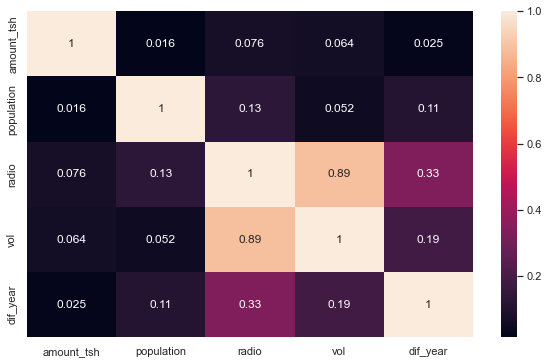

In [18]:
plt.figure(figsize= (10,6))
sns.heatmap(X_train[numerical].corr() , annot= True)
plt.show()

Vemos como radio y vol están correlacionadas, es normal ya que parten de las mismas columnas. Aún así, no voy a tocarlas

##### Categoricas

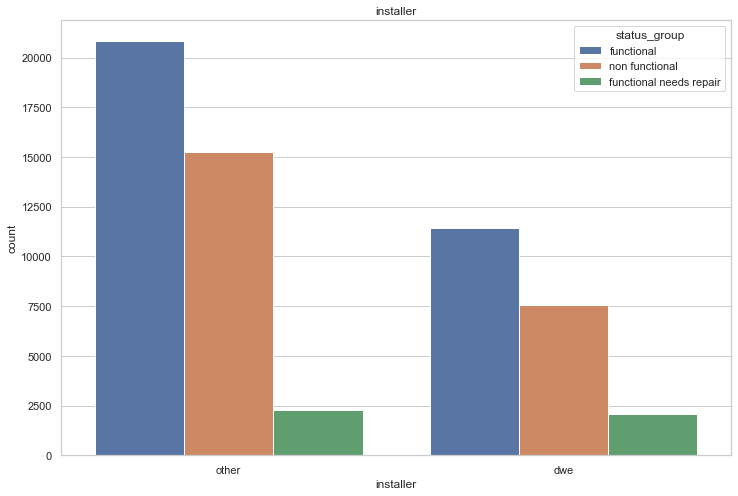

installer  status_group           
dwe        functional                 19.249158
           functional needs repair     3.471380
           non functional             12.734007
other      functional                 35.058923
           functional needs repair     3.796296
           non functional             25.690236
Name: basin, dtype: float64
------------------


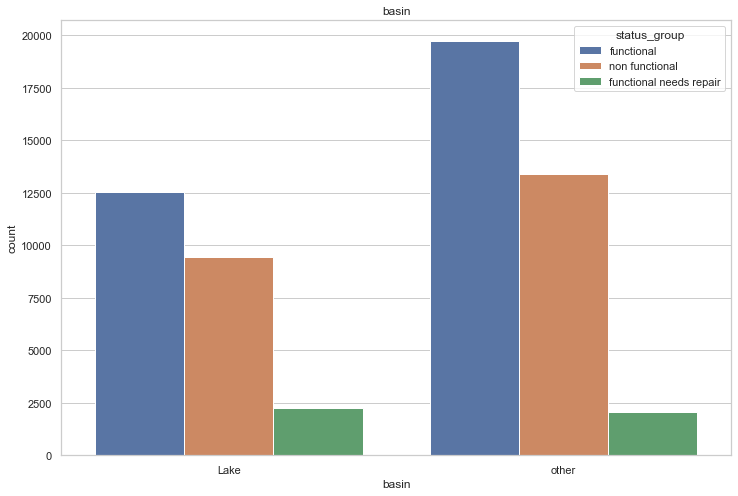

basin  status_group           
Lake   functional                 21.095960
       functional needs repair     3.789562
       non functional             15.887205
other  functional                 33.212121
       functional needs repair     3.478114
       non functional             22.537037
Name: installer, dtype: float64
------------------


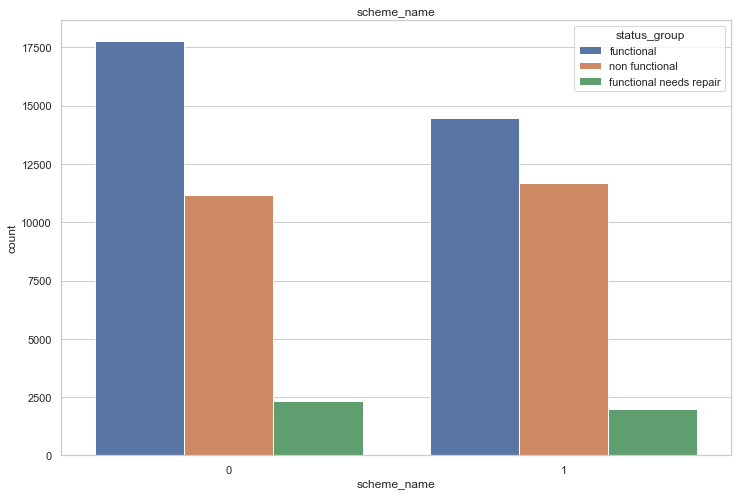

scheme_name  status_group           
0            functional                 29.917508
             functional needs repair     3.893939
             non functional             18.771044
1            functional                 24.390572
             functional needs repair     3.373737
             non functional             19.653199
Name: installer, dtype: float64
------------------


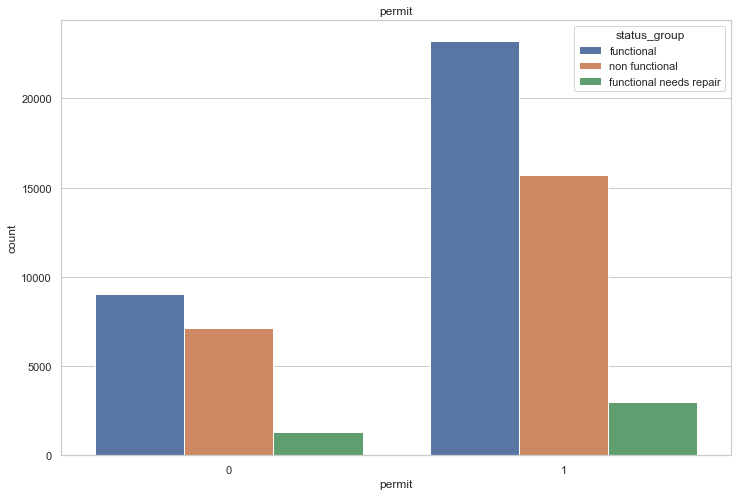

permit  status_group           
0       functional                 15.227273
        functional needs repair     2.222222
        non functional             11.998316
1       functional                 39.080808
        functional needs repair     5.045455
        non functional             26.425926
Name: installer, dtype: float64
------------------


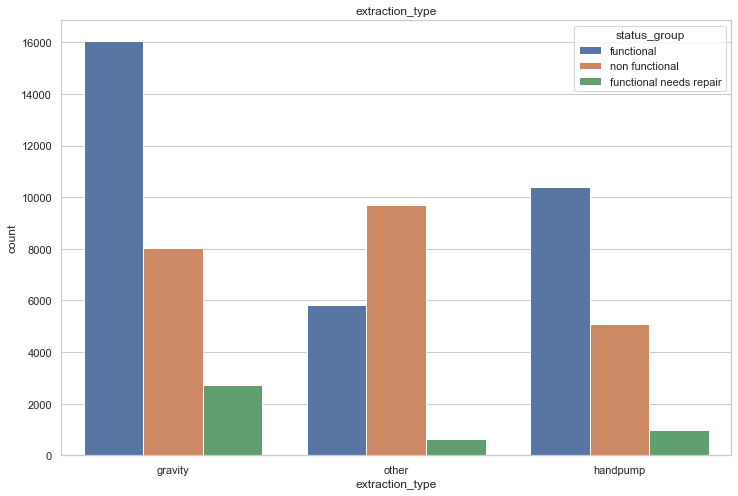

extraction_type  status_group           
gravity          functional                 27.016835
                 functional needs repair     4.547138
                 non functional             13.520202
handpump         functional                 17.466330
                 functional needs repair     1.675084
                 non functional              8.562290
other            functional                  9.824916
                 functional needs repair     1.045455
                 non functional             16.341751
Name: installer, dtype: float64
------------------


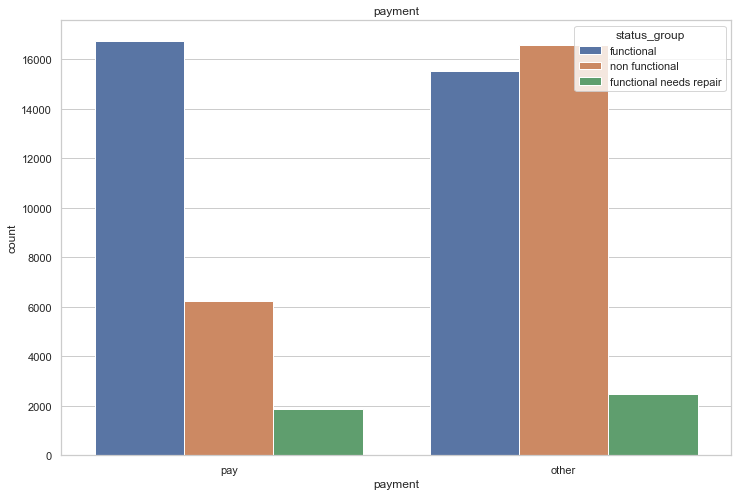

payment  status_group           
other    functional                 26.124579
         functional needs repair     4.136364
         non functional             27.919192
pay      functional                 28.183502
         functional needs repair     3.131313
         non functional             10.505051
Name: installer, dtype: float64
------------------


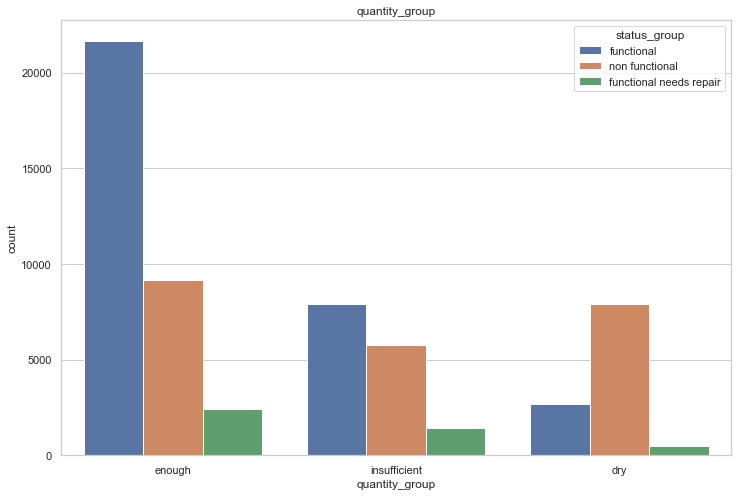

quantity_group  status_group           
dry             functional                  4.537037
                functional needs repair     0.786195
                non functional             13.338384
enough          functional                 36.444444
                functional needs repair     4.040404
                non functional             15.383838
insufficient    functional                 13.326599
                functional needs repair     2.441077
                non functional              9.702020
Name: installer, dtype: float64
------------------


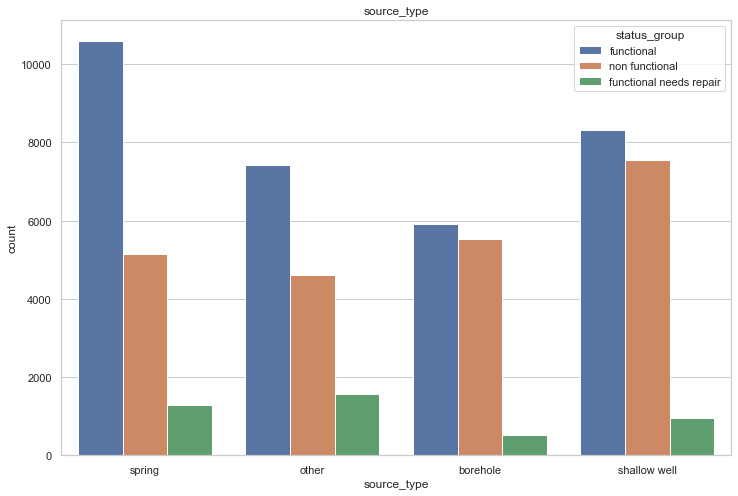

source_type   status_group           
borehole      functional                  9.964646
              functional needs repair     0.855219
              non functional              9.296296
other         functional                 12.498316
              functional needs repair     2.653199
              non functional              7.754209
shallow well  functional                 14.013468
              functional needs repair     1.611111
              non functional             12.698653
spring        functional                 17.831650
              functional needs repair     2.148148
              non functional              8.675084
Name: installer, dtype: float64
------------------


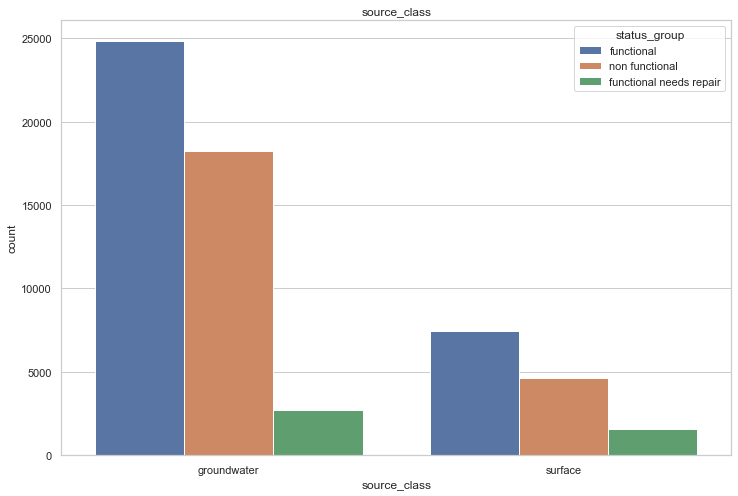

source_class  status_group           
groundwater   functional                 41.809764
              functional needs repair     4.614478
              non functional             30.670034
surface       functional                 12.498316
              functional needs repair     2.653199
              non functional              7.754209
Name: installer, dtype: float64
------------------


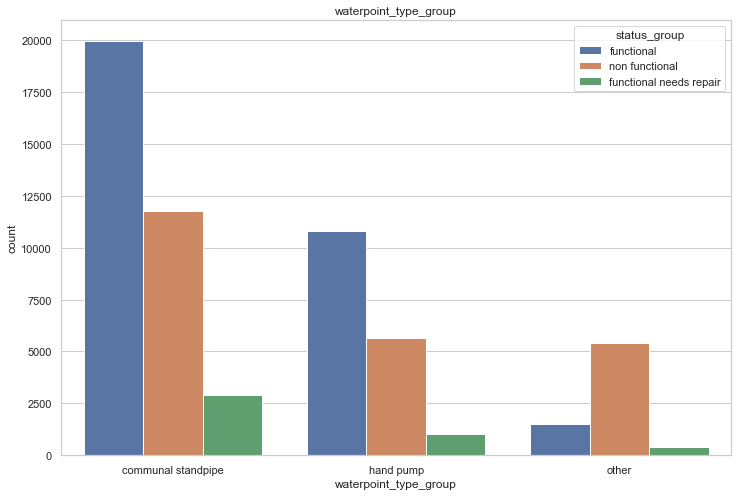

waterpoint_type_group  status_group           
communal standpipe     functional                 33.604377
                       functional needs repair     4.895623
                       non functional             19.791246
hand pump              functional                 18.190236
                       functional needs repair     1.732323
                       non functional              9.518519
other                  functional                  2.513468
                       functional needs repair     0.639731
                       non functional              9.114478
Name: installer, dtype: float64
------------------


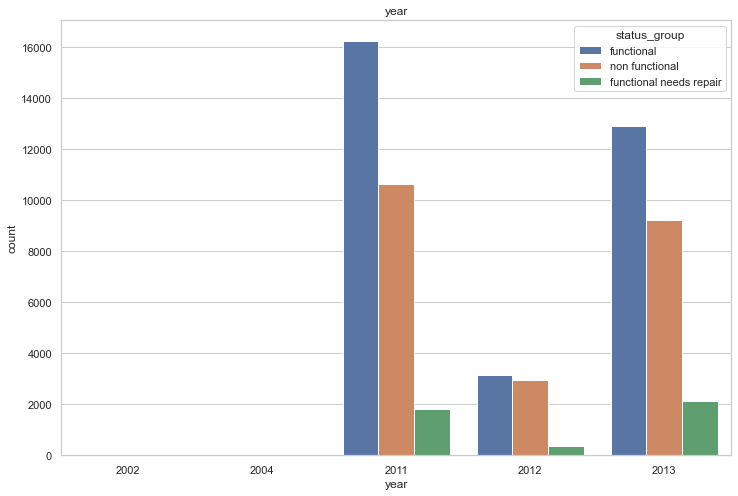

year  status_group           
2002  functional                  0.001684
2004  functional                  0.016835
      functional needs repair     0.001684
      non functional              0.031987
2011  functional                 27.306397
      functional needs repair     3.050505
      non functional             17.915825
2012  functional                  5.262626
      functional needs repair     0.609428
      non functional              4.942761
2013  functional                 21.720539
      functional needs repair     3.606061
      non functional             15.533670
Name: installer, dtype: float64
------------------


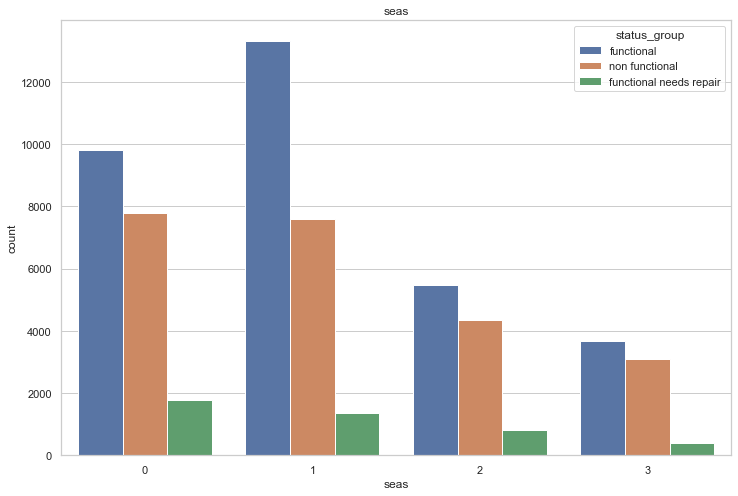

seas  status_group           
0     functional                 16.533670
      functional needs repair     2.966330
      non functional             13.121212
1     functional                 22.407407
      functional needs repair     2.269360
      non functional             12.767677
2     functional                  9.198653
      functional needs repair     1.365320
      non functional              7.345118
3     functional                  6.168350
      functional needs repair     0.666667
      non functional              5.190236
Name: installer, dtype: float64
------------------


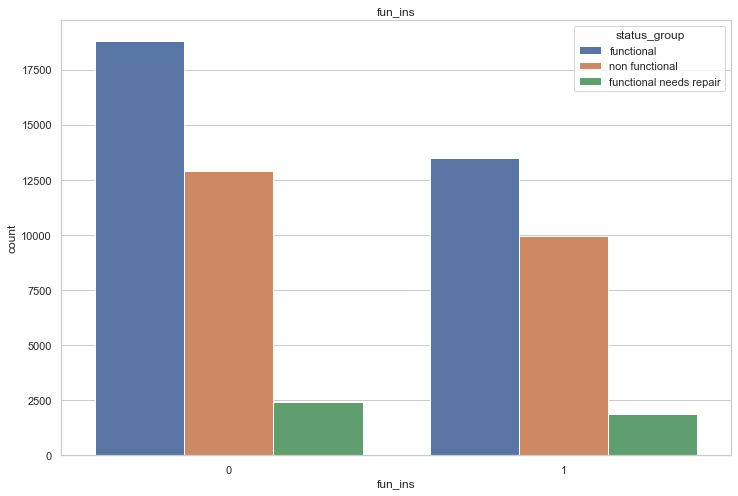

fun_ins  status_group           
0        functional                 31.631313
         functional needs repair     4.080808
         non functional             21.703704
1        functional                 22.676768
         functional needs repair     3.186869
         non functional             16.720539
Name: installer, dtype: float64
------------------


In [19]:
for cat in categorical:
    plt.figure(figsize=(12,8))
    sns.countplot(data = X_train, x = X_train[cat], hue='status_group')
    plt.title(cat)
    plt.show()
    print(X_train[categorical+['status_group']].groupby([cat,'status_group']).count().iloc[:,0] *100 / len(X_train) )
    print("------------------")

##### Encoder

In [20]:
df = pd.get_dummies(df , 
    columns = ['installer', 'basin', 'scheme_name', 'permit','extraction_type', 'payment', 'quantity_group',  'source_type', 'source_class', 'waterpoint_type_group', 'seas', 'fun_ins'], 
    drop_first= True)

,amount_tsh,population,status_group,year,dif_year,radio,vol,installer_other,basin_other,scheme_name_1,permit_1,extraction_type_handpump,extraction_type_other,payment_pay,quantity_group_enough,quantity_group_insufficient,source_type_other,source_type_shallow well,source_type_spring,source_class_surface,waterpoint_type_group_hand pump,waterpoint_type_group_other,seas_1,seas_2,seas_3,fun_ins_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,300.00,0.390698,functional,2011,0.293103,0.500669,0.125502,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
8776,0.00,1.186047,functional,2013,0.137931,0.503895,0.127944,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1
34310,1.25,1.046512,functional,2013,0.155172,0.247380,0.015139,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0
67743,0.00,0.153488,non functional,2013,0.551724,0.095791,0.000879,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
19728,0.00,-0.116279,functional,2011,0.120690,0.011229,0.000001,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,0.00,-0.023256,0,2011,0.120690,0.018741,0.000007,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1
18990,50.00,13.651163,0,2011,0.120690,0.013622,0.000003,1,1,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1
28749,0.00,0.813953,0,2013,0.137931,0.531614,0.150241,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0


In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
enc = LabelEncoder()

df['year'] = enc.fit_transform(df['year'])

In [25]:
X_train = df[:len(X_train)]
X_test = df[len(X_train):]

y_train = X_train[['status_group']]
y_test = X_test[['status_group']]

X_train = X_train.drop(['status_group'], axis = 1)
X_test = X_test.drop(['status_group'], axis = 1)